<a href="https://colab.research.google.com/github/IllgamhoDuck/googleXproject/blob/master/Quantum_Fourier_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Fourier with Tensornetwork quantum simulator
**Implement Quantum Fourier Transform using using Tensornetwork**



## Setting environment
- package install
- package import
- quantum simulator code

In [0]:
!pip install --quiet tensornetwork jax jaxlib qiskit nxpd pylatexenc

     |████████████████████████████████| 235kB 4.7MB/s 
     |████████████████████████████████| 122kB 15.4MB/s 
     |████████████████████████████████| 2.9MB 18.7MB/s 
     |████████████████████████████████| 2.7MB 51.9MB/s 
     |████████████████████████████████| 18.2MB 167kB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 1.4MB 72.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 5.6MB 66.1MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 24.3MB 132kB/s 
     |████████████████████████████████| 573kB 48.0MB/s 
     |████████████████████████████████| 2.3MB 47.3MB/s 


In [0]:
%matplotlib inline

# qiskit - test and visualize
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

# tensornetwork
import numpy as np
import jax
import tensornetwork as tn
# np = jax.numpy

# math
import math

# test
import os
import time
import random
from tqdm import tqdm_notebook as tqdm

In [0]:
tn.set_default_backend("numpy") # <--- Super fast
# tn.set_default_backend("jax") # <--- This is painfully slow
# tn.set_default_backend("tensorflow") # <--- Slow :(
# tn.set_default_backend("pytorch") # <--- Doesn't support complex datatype :(
qasm_simulator = Aer.get_backend('qasm_simulator')
statevector_simulator = Aer.get_backend('statevector_simulator')

class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    CEND      = '\33[0m'
    CBOLD     = '\33[1m'
    CITALIC   = '\33[3m'
    CURL      = '\33[4m'
    CBLINK    = '\33[5m'
    CBLINK2   = '\33[6m'
    CSELECTED = '\33[7m'

    CBLACK  = '\33[30m'
    CRED    = '\33[31m'
    CGREEN  = '\33[32m'
    CYELLOW = '\33[33m'
    CBLUE   = '\33[34m'
    CVIOLET = '\33[35m'
    CBEIGE  = '\33[36m'
    CWHITE  = '\33[37m'

    CBLACKBG  = '\33[40m'
    CREDBG    = '\33[41m'
    CGREENBG  = '\33[42m'
    CYELLOWBG = '\33[43m'
    CBLUEBG   = '\33[44m'
    CVIOLETBG = '\33[45m'
    CBEIGEBG  = '\33[46m'
    CWHITEBG  = '\33[47m'

    CGREY    = '\33[90m'
    CRED2    = '\33[91m'
    CGREEN2  = '\33[92m'
    CYELLOW2 = '\33[93m'
    CBLUE2   = '\33[94m'
    CVIOLET2 = '\33[95m'
    CBEIGE2  = '\33[96m'
    CWHITE2  = '\33[97m'

    CGREYBG    = '\33[100m'
    CREDBG2    = '\33[101m'
    CGREENBG2  = '\33[102m'
    CYELLOWBG2 = '\33[103m'
    CBLUEBG2   = '\33[104m'
    CVIOLETBG2 = '\33[105m'
    CBEIGEBG2  = '\33[106m'
    CWHITEBG2  = '\33[107m'

color = colors

In [0]:
class QuantumSimulator():
    """Quantum simulator with tensornetwork"""
    def __init__(self, qbit_n):
        """
        Args:
            qbit_n: The number of total qubit size
            circuit: Where to store gate
        """
        assert qbit_n > 0, "Qubit size should be at least 1"
        self.qbit_n = qbit_n
        self.circuit = []

    def initialize_circuit(self):
        """
        Initialize the circuit to execute

        Args:
            qbits: Store the first initialized qubits
            measures: Store the edge that used for measure for each qubit
        """
        # Initialize qubit
        self.qbits = [tn.Node(np.array([1 + 0j, 0 + 0j])) for _ in range(self.qbit_n)]

        # Storing the Edge node that will be used to measure for each qubit
        self.measures = [self.qbits[i][0] for i in range(self.qbit_n)]
        self.amplitude = None
        self.result = {}
        self.result_prob = {}
    
    def connect_qubits(self):
        """
        Make the seperate tensornetworks to one tensornetwork using
        2 qubit identity gate
        CI - Control Identity
             [[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]
        """
        for i in range(self.qbit_n - 1):
            self.add_ci(i, i + 1)

    def x(self, qbit_i):
        """
        Add X gate to specific 1 qubit index 
        x(qbit_i=0)
        """
        self.circuit.append(('x', qbit_i))

    def y(self, qbit_i):
        """
        Add Y gate to specific 1 qubit index 
        y(qbit_i=5)
        """
        self.circuit.append(('y', qbit_i))

    def z(self, qbit_i):
        """
        Add Z gate to specific 1 qubit index 
        z(qbit_i=3)
        """
        self.circuit.append(('z', qbit_i))

    def h(self, qbit_i):
        """
        Add H gate to specific 1 qubit index 
        h(qbit_i=2)
        """
        self.circuit.append(('h', qbit_i))

    def t(self, qbit_i):
        """
        Add T gate to specific 1 qubit index 
        t(qbit_i=0)
        """
        self.circuit.append(('t', qbit_i))
    
    def u1(self, gamma, qbit_i):
        """
        Add U1 gate to specific 1 qubit index 
        u1(gamma=math.pi, qbit_i=0)
        """
        self.circuit.append(('u1', gamma, qbit_i))

    def swap(self, qbit_c, qbit_t):
        """
        Add SWAP gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('swap', qbit_c, qbit_t))

    def cx(self, qbit_c, qbit_t):
        """
        Add CX gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cx(qbit_c=0, qbit_t=1)
        """
        self.circuit.append(('cx', qbit_c, qbit_t))

    def cy(self, qbit_c, qbit_t):
        """
        Add CY gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cy(qbit_c=3, qbit_t=2)
        """
        self.circuit.append(('cy', qbit_c, qbit_t))

    def cz(self, qbit_c, qbit_t):
        """
        Add CZ gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cz(qbit_c=2, qbit_t=4)
        """
        self.circuit.append(('cz', qbit_c, qbit_t))

    def ch(self, qbit_c, qbit_t):
        """
        Add CH gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        ch(qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('ch', qbit_c, qbit_t))
    
    def cu1(self, gamma, qbit_c, qbit_t):
        """
        Add Phase shift CU1 gate to specific 2 qubit(control / target) index
        control and target qubit must be different 
        cu1(gamma=math.pi / 4, qbit_c=1, qbit_t=3)
        """
        self.circuit.append(('cu1', gamma, qbit_c, qbit_t))
    
    def ccx(self, qbit_c1, qbit_c2, qbit_t):
        """
        Add CCX gate to specific 3 qubit(control1 / control2 / target) index
        control and target qubit must be different 
        ccx(qbit_c1=0, qbit_c2=1 qbit_t=2)
        """
        self.circuit.append(('ccx', qbit_c1, qbit_c2, qbit_t))

    def add_x(self, qbit_i):
        X = tn.Node(np.array([[0, 1],
                              [1, 0]]))
        self.measures[qbit_i] ^ X[0]
        self.measures[qbit_i] = X[1]

    def add_y(self, qbit_i):
        Y = tn.Node(np.array([[0, 1j],
                              [-1j, 0]]))
        self.measures[qbit_i] ^ Y[0]
        self.measures[qbit_i] = Y[1]

    def add_z(self, qbit_i):
        Z = tn.Node(np.array([[1, 0],
                              [0, -1]]))
        self.measures[qbit_i] ^ Z[0]
        self.measures[qbit_i] = Z[1]

    def add_h(self, qbit_i):
        h_f = 1/math.sqrt(2)
        H = tn.Node(np.array([[h_f, h_f],
                              [h_f, -h_f]]))
        self.measures[qbit_i] ^ H[0]
        self.measures[qbit_i] = H[1]

    def add_t(self, qbit_i):
        e_j_pi = math.e ** ((1j * math.pi) / 4)
        T = tn.Node(np.array([[1, 0],
                              [0, e_j_pi]]))
        self.measures[qbit_i] ^ T[0]
        self.measures[qbit_i] = T[1]
    
    def add_u1(self, gamma, qbit_i):
        shift = math.e ** (1j * gamma)
        U1 = tn.Node(np.array([[1, 0],
                               [0, shift]]))
        self.measures[qbit_i] ^ U1[0]
        self.measures[qbit_i] = U1[1]
    
    def add_swap(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        swap = np.array([[1, 0, 0, 0],
                         [0, 0, 1, 0],
                         [0, 1, 0, 0],
                         [0, 0, 0, 1]])
        SWAP = tn.Node(swap.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ SWAP[0]
        self.measures[qbit_t] ^ SWAP[1]
        self.measures[qbit_c] = SWAP[2]
        self.measures[qbit_t] = SWAP[3]

    def add_cx(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cx = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0, 1, 0]])
        CX = tn.Node(cx.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CX[0]
        self.measures[qbit_t] ^ CX[1]
        self.measures[qbit_c] = CX[2]
        self.measures[qbit_t] = CX[3]

    def add_cy(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cy = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 0, 1j],
                       [0, 0, -1j, 0]])
        CY = tn.Node(cy.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CY[0]
        self.measures[qbit_t] ^ CY[1]
        self.measures[qbit_c] = CY[2]
        self.measures[qbit_t] = CY[3]


    def add_cz(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        cz = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]])
        CZ = tn.Node(cz.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CZ[0]
        self.measures[qbit_t] ^ CZ[1]
        self.measures[qbit_c] = CZ[2]
        self.measures[qbit_t] = CZ[3]

    def add_ch(self, qbit_c, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            h_f: hadamard factor
        """
        h_f = 1/math.sqrt(2)
        ch = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, h_f, h_f],
                       [0, 0, h_f, -h_f]])
        CH = tn.Node(ch.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CH[0]
        self.measures[qbit_t] ^ CH[1]
        self.measures[qbit_c] = CH[2]
        self.measures[qbit_t] = CH[3]

    def add_ci(self, qbit_c, qbit_t):
        """
        Control Identity matrix for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ci = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
        CI = tn.Node(ci.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CI[0]
        self.measures[qbit_t] ^ CI[1]
        self.measures[qbit_c] = CI[2]
        self.measures[qbit_t] = CI[3]
    
    def add_cu1(self, gamma, qbit_c, qbit_t):
        """
        Control Phase Shift gate U1 for connect
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
            gamma: Phase shift value
        """
        shift = math.e ** (1j * gamma)
        cu1 = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, shift]])
        CU1 = tn.Node(cu1.reshape((2, 2, 2, 2)))
        self.measures[qbit_c] ^ CU1[0]
        self.measures[qbit_t] ^ CU1[1]
        self.measures[qbit_c] = CU1[2]
        self.measures[qbit_t] = CU1[3]

    def add_ccx(self, qbit_c1, qbit_c2, qbit_t):
        """
        Args:
            qbit_c: Quantum qubit control
            qbit_t: Quantum qubit target
        """
        ccx = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 1, 0]])
        CCX = tn.Node(ccx.reshape((2, 2, 2, 2, 2, 2)))
        self.measures[qbit_c1] ^ CCX[0]
        self.measures[qbit_c2] ^ CCX[1]
        self.measures[qbit_t] ^ CCX[2]
        self.measures[qbit_c1] = CCX[3]
        self.measures[qbit_c2] = CCX[4]
        self.measures[qbit_t] = CCX[5]

    def generate_qiskit_circuit(self):
        """Visualize the gate using Qiskit"""
        qasm = self.circuit_to_qasm(self.circuit, self.qbit_n)
        statevector = self.circuit_to_qasm(self.circuit, self.qbit_n, False)
        ibmq_circuit_qasm = QuantumCircuit.from_qasm_str(qasm)
        ibmq_circuit_statevector = QuantumCircuit.from_qasm_str(statevector)
        return ibmq_circuit_qasm, ibmq_circuit_statevector

    def circuit_to_qasm(self, circuit, qubit_size, measure=True):
        # Add meta data
        qasm_text = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'

        # Add quantum bits and classical bits
        qasm_text += 'qreg q[{0}];\ncreg c[{0}];\n'.format(qubit_size)

        # Add quantum gates
        for gate in circuit:
            # 1 qubit gate
            if len(gate) == 2 or gate[0] == 'u1':
                if (gate[0] == 'u1'):
                    qasm_text += '{0}({1}) q[{2}];\n'.format(gate[0], gate[1], gate[2])
                else:
                    qasm_text += '{0} q[{1}];\n'.format(gate[0], gate[1])
            # 2 qubit gate
            elif len(gate) == 3 or gate[0] == 'cu1':
                if (gate[0] == 'cu1'):
                    qasm_text += '{0}({1}) q[{2}],q[{3}];\n'.format(gate[0], gate[1], gate[2], gate[3])
                else:
                    qasm_text += '{0} q[{1}],q[{2}];\n'.format(gate[0], gate[1], gate[2])
            elif len(gate) == 4:
                qasm_text += '{0} q[{1}],q[{2}],q[{3}];\n'.format(gate[0],
                                                                  gate[1],
                                                                  gate[2],
                                                                  gate[3])
            else:
                raise NotImplementedError("Quantum simulator doesn't support qubit gates more than 3")

        # Add measure gate
        if measure == True:
            for qbit_i in range(qubit_size):
                qasm_text += 'measure q[{0}] -> c[{0}];\n'.format(qbit_i)

        return qasm_text

    def generate_result(self):
        for i in range(2 ** self.qbit_n):
            # Generate statevector
            statevector = ""
            for shift in range(self.qbit_n):
                statevector = str((i >> shift) & 1) + statevector
            
            # Check the amplitude
            amp = self.amplitude[self.bitstring_to_int(statevector)]
            amp = complex(str(amp))

            if amp == 0:
                continue

            # TODO: Figure out how to get value out of jax array
            self.result[statevector] = amp 
            self.result_prob[statevector] = (amp*amp.conjugate()).real

    def bitstring_to_int(self, bitstring):
        int_list = []
        for i in bitstring[::-1]:
            int_list.append(int(i))
        return tuple(int_list)

    def execute_circuit(self):
        """
        gate is structed as following
        1 qubit gate - (gate_name, qubit_index)
        2 qubit gate - (gate_name, qubit_control_index, qubit_target_index)
        """
        gate_1 = ['x', 'y', 'z', 'h', 't', 'u1']
        gate_2 = ['swap', 'cx', 'cy', 'cz', 'ch', 'cu1']
        gate_3 = ['ccx']
        gate_1_func = [self.add_x, self.add_y, self.add_z, self.add_h, self.add_t, self.add_u1]
        gate_2_func = [self.add_swap, self.add_cx, self.add_cy, self.add_cz, self.add_ch, self.add_cu1]
        gate_3_func = [self.add_ccx]

        # Connect the qubits
        for gate in self.circuit:
            if gate[0] in gate_2:
                i = gate_2.index(gate[0])
                if gate[0] == 'cu1':
                    gate_2_func[i](gate[1], gate[2], gate[3])
                else:
                    gate_2_func[i](gate[1], gate[2])
            elif gate[0] in gate_1:
                i = gate_1.index(gate[0])
                if gate[0] == 'u1':
                    gate_1_func[i](gate[1], gate[2])
                else:
                    gate_1_func[i](gate[1])
            elif gate[0] in gate_3:
                i = gate_3.index(gate[0])
                gate_3_func[i](gate[1], gate[2], gate[3])
            else:
                raise NotImplementedError("Gate {} is not supported".format(gate[0]))

        nodes = tn.reachable(self.qbits[0])
        self.amplitude = tn.contractors.greedy(nodes, output_edge_order=self.measures).tensor

    def clear_circuit(self):
        self.circuit = []

    def change_qubit_size(self, size):
        assert size > 0, "Qubit size should be at least 1"
        self.qbit_n = size

    def execute(self):
        assert self.qbit_n > 0, "Qubit size should be at least 1"
        self.initialize_circuit()
        self.connect_qubits()
        self.execute_circuit()
        self.generate_result()


## Phase Shift Controlled U1 (Parametrized Gate) & U1 & SWAP gate test

#### **Parametrized cu1 & u1 & swap Gate Test code**



In [0]:
class QuantumSimulatorTest():
    """Test the quantum simulator"""
    def __init__(self,
                 min_qubit_size=1,
                 max_qubit_size=5,
                 min_gate_size=1,
                 max_gate_size=40):
        """
        Choose the testing enviroment
        Args:
            min_qubit_size: minimum number of the qubit size
            min_qubit_size: maximum number of the qubit size
            min_qubit_size: minimum number of the gate size
            min_qubit_size: maximum number of the gate size
        """
        self.max_qubit_size = max_qubit_size
        self.min_qubit_size = min_qubit_size
        self.max_gate_size = max_gate_size
        self.min_gate_size = min_gate_size

    def __call__(self,
                 quantum_simulator,
                 ibmq_backend,
                 test_size=10,
                 error_path=None,
                 error_file=None):
        """
        Process test
        Quantum simulator testing using ibmq qiskit
        Args:
            quantum_simulator: quantum simulator that will be used to simulate
            ibmq_backend: ibmq simulator that will be used as reference
                - qasm_simulator: show the number of shots for each statevector
                - statevector_simualtor: show the amplitude and prob for each statevector
                                         measure gates are disabled
            test_size: total test case size
            error_path: where to store the error case
            error_file: name of the error file
        """
        # Check IBMQ backend
        self.ibmq_backend = ibmq_backend.configuration().backend_name

        # Check the correct
        total = 0
        correct = 0
        test_start_time = time.time()

        # Store the error case
        if error_path:
            if not(os.path.isdir(error_path)):
                os.makedirs(error_path)
            f = open(os.path.join(error_path, error_file), 'w')

        # Run the test!
        for test_i in tqdm(range(test_size)):
            # Generate the random circuit and qasm(IBM Qiskit)
            random_qubit_size = random.randint(self.min_qubit_size, self.max_qubit_size)
            random_gate_size = random.randint(self.min_gate_size, self.max_gate_size)
            circuit, qasm = self.random_circuit(random_qubit_size, random_gate_size)

            # Print out the current test case information
            print(color.BOLD)
            print('TEST CASE [{} / {}] qubit: {} gate: {}'.format(test_i + 1,
                                                                  test_size,
                                                                  random_qubit_size,
                                                                  random_gate_size))
            print(color.ENDC)

            # Run the Quantum simulator and get the result
            qs_start_time = time.time()
            quantum_simulator.change_qubit_size(random_qubit_size)
            quantum_simulator.circuit = circuit
            quantum_simulator.execute()
            qs_end_time = time.time()

            self.qs_result = quantum_simulator.result_prob

            # Run IBM qiskit simulator and get the result
            shots = 1000 # default

            ibmq_start_time = time.time()
            ibmq_circuit = QuantumCircuit.from_qasm_str(qasm)
            self.ibmq_result = execute(ibmq_circuit, ibmq_backend, shots=shots).result()
            ibmq_end_time = time.time()

            ############################################################
            ### PRINT OUT THE INFORMATIONS #############################
            ############################################################

            # 1. Circuit information
            print(circuit)
            print(ibmq_circuit)

            # 2. Quantum simulation
            print(color.BOLD + '[ QUANTUM SIMULATOR ]' + color.ENDC)
            print(color.CURL, end="")
            print("Quantum simulator tested time: %s sec\n" % format(qs_end_time - qs_start_time))
            print(color.ENDC, end="")
            print(quantum_simulator.result)
            print(self.qs_result)
            print('')

            # 3. IBMQ simulation
            print(color.BOLD + '[ IBM QISKIT ]' + color.ENDC)
            print(color.CURL, end="")
            print("IBMQ tested time: %s sec\n" % format(ibmq_end_time - ibmq_start_time))
            print(color.ENDC, end="")
            if self.ibmq_backend == 'qasm_simulator':
                print(self.ibmq_result.get_counts())
            if self.ibmq_backend == 'statevector_simulator':
                self.generate_ibmq_result(random_qubit_size)
                print(self.ibmq_amp)
                print(self.ibmq_prob)
            print('')

            # 4. Compare the result
            print(color.BOLD + '[ COMPARE ]' + color.ENDC)
            cmp_start_time = time.time()
            error_n, cmp_total, total_error = self.compare_probability(shots)
            print(color.CURL, end="")
            print("Comparing time: %s sec" % format(time.time() - cmp_start_time))
            print(color.ENDC)
            if error_n == 0:
                print(color.OKBLUE + 'ERROR OCCUR / TOTAL CHECK: ' + color.ENDC, error_n, '/', cmp_total)
                print(color.OKBLUE + 'TOTAL ERROR: ' + color.ENDC, total_error,'\n')
            else:
                print(color.FAIL + 'ERROR OCCUR / TOTAL CHECK: ' + color.ENDC, error_n, '/', cmp_total)
                print(color.FAIL + 'TOTAL ERROR: ' + color.ENDC, total_error,'\n')

            ############################################################
            ############################################################
            ############################################################

            # Update the error information and save the error case to file
            if error_n == 0:
                correct += 1
            elif error_path and self.ibmq_backend == 'qasm_simulator':
                error_case = ""
                error_case += str(circuit) + '\n'
                error_case += '< Quantum simulator probability >\n'
                error_case += str(self.qs_result) +'\n'
                error_case += '< IBMQ statevector count information >\n'
                error_case += str(self.ibmq_result.get_counts()) + '\n'
                error_case += 'Error occur / Total check: '
                error_case += str(error_n) + '/' + str(cmp_total) + '\n'
                error_case += 'Total error: '
                error_case += str(total_error) + '\n\n'
                f.write(error_case)
            elif error_path and self.ibmq_backend == 'statevector_simulator':
                error_case = ""
                error_case += str(circuit) + '\n'
                error_case += '< Quantum simulator amplitude & probability >\n'
                error_case += str(quantum_simulator.result) +'\n'
                error_case += str(self.qs_result) +'\n'
                error_case += '< IBMQ amplitude & probability >\n'
                error_case += str(self.ibmq_amp) + '\n'
                error_case += str(self.ibmq_prob) + '\n'
                error_case += 'Error occur / Total check: '
                error_case += str(error_n) + '/' + str(cmp_total) + '\n'
                error_case += 'Total error: '
                error_case += str(total_error) + '\n\n'
                f.write(error_case)
            total += 1

        # Close the error case file
        if error_path:
            f.close()

        # Print out the final result
        if correct == total:
            print(color.OKBLUE + "The final result is {} / {}".format(correct, total) + color.ENDC)
        else:
            print(color.FAIL + "The final result is {} / {}".format(correct, total) + color.ENDC)
        print("Total tested time: %s sec" % format(time.time() - test_start_time))

    def generate_ibmq_result(self, qubit_size):
        """
        Generate statevector dictionary stores probability of ibmq simulator
        based on amplitude from ibmq statevector simulator
        """
        ibmq_amplitude = self.ibmq_result.data()['statevector']
        self.ibmq_amp = {}
        self.ibmq_prob = {}
        for i in range(2 ** qubit_size):
            # Generate statevector
            statevector = ""
            for shift in range(qubit_size):
                statevector = str((i >> shift) & 1) + statevector

            # Check the amplitude
            amp_list = ibmq_amplitude[i]
            amp = complex(amp_list[0], amp_list[1])

            if amp == 0:
                continue

            self.ibmq_amp[statevector] = amp
            self.ibmq_prob[statevector] = (amp*amp.conjugate()).real

    def compare_probability(self, shots, delta=1e-6):
        """
        Check each statevector probability and if the value is
        more than give delta(default: 1e-6) value consider as error
        """
        total_error = 0
        error_n = 0
        cmp_total = 0

        # Get statevector info from both simulator
        if self.ibmq_backend == 'qasm_simulator':
            ibmq_count = self.ibmq_result.get_counts()
            state_vectors = list(set(self.qs_result.keys()).union(set(ibmq_count.keys())))
        if self.ibmq_backend == 'statevector_simulator':
            state_vectors = list(set(self.qs_result.keys()).union(set(self.ibmq_amp.keys())))

        # Check is there is an error
        for state_vector in state_vectors:
            qs_val = self.qs_result.get(state_vector, 0)

            if self.ibmq_backend == 'qasm_simulator':
                ibmq_val = ibmq_count.get(state_vector, 0)/shots
            if self.ibmq_backend == 'statevector_simulator':
                ibmq_val = self.ibmq_prob.get(state_vector, 0)

            error = abs(qs_val - ibmq_val)
            total_error += error
            if error > delta:
                error_n += 1
            cmp_total += 1

        return error_n, cmp_total, total_error

    def random_circuit(self, qubit_size=5, gate_size=20):
        """
        Args:
            gate_1: list of 1 qubit gates
            gate_2: list of 2 qubit gates
            qubit_list: list of qubit index
        """
        # Quantum Simulator
        gate_1 = ['x', 'y', 'z', 'u1']
        gate_2 = ['swap', 'cu1'] # 'cx', 'cy', 'cz', 'ch',
        qubit_list = list(range(qubit_size))

        circuit = []
        for _ in range(gate_size):
            if qubit_size == 1 or random.random() > 0.5:
                gate = random.choice(gate_1)
                if gate == 'u1':
                    random_gamma = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    circuit.append(tuple([gate, random_gamma, *random.sample(qubit_list, 1)]))
                else:
                    circuit.append(tuple([gate, *random.sample(qubit_list, 1)]))
            else:
                gate = random.choice(gate_2)
                if gate == 'cu1':
                    random_gamma = random.sample([-1, 1], 1)[0] * random.randint(1, 3) * random.random()
                    circuit.append(tuple([gate, random_gamma, *random.sample(qubit_list, 2)]))
                else:
                    circuit.append(tuple([gate, *random.sample(qubit_list, 2)]))

        # IBM Qiskit
        qasm = self.circuit_to_qasm(circuit, qubit_size)

        return circuit, qasm

    def circuit_to_qasm(self, circuit, qubit_size):
        # Add meta data
        qasm_text = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'

        # Add quantum bits and classical bits
        qasm_text += 'qreg q[{0}];\ncreg c[{0}];\n'.format(qubit_size)

        # Add quantum gates
        for gate in circuit:
            # 1 qubit gate
            if len(gate) == 2 or gate[0] == 'u1':
                if (gate[0] == 'u1'):
                    qasm_text += '{0}({1}) q[{2}];\n'.format(gate[0], gate[1], gate[2])
                else:
                    qasm_text += '{0} q[{1}];\n'.format(gate[0], gate[1])
            # 2 qubit gate
            elif len(gate) == 3 or gate[0] == 'cu1':
                if (gate[0] == 'cu1'):
                    qasm_text += '{0}({1}) q[{2}],q[{3}];\n'.format(gate[0], gate[1], gate[2], gate[3])
                else:
                    qasm_text += '{0} q[{1}],q[{2}];\n'.format(gate[0], gate[1], gate[2])
            else:
                raise NotImplementedError("Quantum simulator doesn't support qubit gates more than 2")

        # Add measure gate
        if self.ibmq_backend == 'qasm_simulator':
            for qbit_i in range(qubit_size):
                qasm_text += 'measure q[{0}] -> c[{0}];\n'.format(qbit_i)

        return qasm_text


#### **Parametrized cu1 & u1 & swap Gate Test**

In [0]:
t = QuantumSimulatorTest(min_qubit_size=1,
                         max_qubit_size=10,
                         min_gate_size=10,
                         max_gate_size=50)
circuit = QuantumSimulator(1)

In [0]:
t(quantum_simulator=circuit,
  ibmq_backend=statevector_simulator,
  test_size=50)


TEST CASE [1 / 50] qubit: 9 gate: 15

[('swap', 1, 0), ('cu1', -2.8442799997264725, 3, 8), ('z', 2), ('x', 8), ('x', 0), ('y', 0), ('u1', -1.665438563176845, 2), ('y', 1), ('swap', 1, 8), ('cu1', 0.04562045134560622, 4, 5), ('swap', 0, 6), ('y', 6), ('cu1', -0.709354764418338, 0, 6), ('z', 2), ('u1', -1.8503457548745839, 0)]
                               ┌───┐             ┌───┐                      »
q_0: |0>────X──────────────────┤ X ├─────────────┤ Y ├────X───────■─────────»
            │                  ├───┤             └───┘    │       │         »
q_1: |0>────X──────────────────┤ Y ├───────────────────X──┼───────┼─────────»
          ┌───┐           ┌────┴───┴────┐        ┌───┐ │  │       │         »
q_2: |0>──┤ Z ├───────────┤ U1(-1.6654) ├────────┤ Z ├─┼──┼───────┼─────────»
          └───┘           └─────────────┘        └───┘ │  │       │         »
q_3: |0>───────────■───────────────────────────────────┼──┼───────┼─────────»
                   │                            

## Introduction to Quantum Fourier Transform

1. What is Quantum Fourier Transform?
3. Where is it used for?


In [0]:
#@title DUCKY!
%%html
<marquee style='width: 100%; color: blue;'><b>DUCKY! DUCKY! DUCKY! DUCKY! DUCKY!</b></marquee>

### 1. What is Quantum Fourier Transform?
    It is quantum analogue of classic inverse discrete
    fourier transform which was a algorithm to apply 
    fourier transform to computers that can only 
    accept discrete value

    It transform over the amplitude of a wave function

 1. Fourier Transform
 2. Inverse discrete fourier transform
 3. Quantum fourier transfrom

 
    Before going to Qunatum Fourier Transform
    let's check the bottom knowledge


**Fourier Transform**

The Fourier transform (FT) decomposes a function of time (a signal) into its constituent frequencies. This is similar to the way a musical chord can be expressed in terms of the volumes and frequencies of its constituent notes. The term Fourier transform refers to both the frequency domain representation and the mathematical operation that associates the frequency domain representation to a function of time. The Fourier transform of a function of time is itself a complex-valued function of frequency, whose magnitude (modulus) represents the amount of that frequency present in the original function, and whose argument is the phase offset of the basic sinusoid in that frequency. The Fourier transform is not limited to functions of time, but the domain of the original function is commonly referred to as the time domain. There is also an inverse Fourier transform that mathematically synthesizes the original function from its frequency domain representation.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif" width=400px>

“Fourier Transform.” Wikipedia, Wikimedia Foundation, 29 Jan. 2020, en.wikipedia.org/wiki/Fourier_transform.

**Inverse discrete Fourier Transform**

The DFT is the most important discrete transform, used to perform Fourier analysis in many practical applications. In digital signal processing, the function is any quantity or signal that varies over time, such as the pressure of a sound wave, a radio signal, or daily temperature readings, sampled over a finite time interval (often defined by a window function). In image processing, the samples can be the values of pixels along a row or column of a raster image. The DFT is also used to efficiently solve partial differential equations, and to perform other operations such as convolutions or multiplying large integers.

$\begin{align}
  X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-\frac {i 2\pi}{N}kn}\\
      &= \sum_{n=0}^{N-1} x_n \cdot \left[\cos\left(\frac{2 \pi}{N}kn\right) - i \cdot \sin\left(\frac{2 \pi}{N}kn\right)\right]
\end{align}$

$\mathbf{x} =
\begin{pmatrix}
x_0 \\ x_1 \\ x_2 \\ x_3
\end{pmatrix}
=
\begin{pmatrix}
1 \\ 2-i \\ -i \\ -1+2i
\end{pmatrix}
$

Here we demonstrate how to calculate the DFT of $\mathbf{x}$

$X_0 = e^{-i 2 \pi 0 \cdot 0 / 4} \cdot 1 + e^{-i 2 \pi 0 \cdot 1 / 4} \cdot (2-i) + e^{-i 2 \pi 0 \cdot 2 / 4} \cdot (-i) + e^{-i 2 \pi 0 \cdot 3 / 4} \cdot (-1+2i) = 2$

$X_1 = e^{-i 2 \pi 1 \cdot 0 / 4} \cdot 1 + e^{-i 2 \pi 1 \cdot 1 / 4} \cdot (2-i) + e^{-i 2 \pi 1 \cdot 2 / 4} \cdot (-i) + e^{-i 2 \pi 1 \cdot 3 / 4} \cdot (-1+2i) = -2-2i$

$X_2 = e^{-i 2 \pi 2 \cdot 0 / 4} \cdot 1 + e^{-i 2 \pi 2 \cdot 1 / 4} \cdot (2-i) + e^{-i 2 \pi 2 \cdot 2 / 4} \cdot (-i) + e^{-i 2 \pi 2 \cdot 3 / 4} \cdot (-1+2i) = -2i$

$X_3 = e^{-i 2 \pi 3 \cdot 0 / 4} \cdot 1 + e^{-i 2 \pi 3 \cdot 1 / 4} \cdot (2-i) + e^{-i 2 \pi 3 \cdot 2 / 4} \cdot (-i) + e^{-i 2 \pi 3 \cdot 3 / 4} \cdot (-1+2i) = 4+4i$

$\mathbf{X} =
\begin{pmatrix}
X_0 \\
X_1 \\
X_2 \\
X_3
\end{pmatrix}
=
\begin{pmatrix}
2 \\
-2-2i \\
-2i \\
4+4i
\end{pmatrix}
$

“Discrete Fourier Transform.” Wikipedia, Wikimedia Foundation, 30 Jan. 2020, en.wikipedia.org/wiki/Discrete_Fourier_transform#Inverse_transform.



**Quantum Fourier Transform**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Q_fourier_nqubits.png/1400px-Q_fourier_nqubits.png" width=700px>

In quantum computing, the quantum Fourier transform (for short: QFT) is a linear transformation on quantum bits, and is the **quantum analogue of the inverse discrete Fourier transform**. The quantum Fourier transform is a part of many quantum algorithms, notably Shor's algorithm for factoring and computing the discrete logarithm, the quantum phase estimation algorithm for estimating the eigenvalues of a unitary operator, and algorithms for the hidden subgroup problem. The quantum Fourier transform was invented by Don Coppersmith.







**Algorithm**

    Following two gates are used as main

$H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}  \qquad  
R_m = \begin{pmatrix} 1 & 0 \\ 0 & e ^ \frac{ 2 \pi i }{2 ^ m}  \end{pmatrix}$

with $e^{\frac{2 \pi i}{2^m}} = \omega_m' = \omega_{\left(2^m\right)} $ the primitive $2^m$-th root of unity. 

The quantum Fourier transform can be approximately implemented for any $N$ however, the implementation for the case where $N$ is a power of 2 is much simpler. As already stated, we assume $N = 2^n$.  We  have the orthonormal basis consisting of the vectors 
$|0\rangle, \ldots , |2^n - 1\rangle$

The basis states enumerate all the possible states of the qubits


$| x \rangle = | x_1 x_2 \ldots x_n \rangle = | x_1 \rangle \otimes | x_2 \rangle \otimes \cdots \otimes | x_n \rangle$

where, with tensor product notation $|x_j\rangle$ indicates that qubit $j$ is in state $x_j$, with $x_j$ either 0 or 1.  By convention, the basis state index $x$ orders the possible states of the qubits lexicographically, i.e., by converting from binary to decimal in this way

    binary notation

**Aware that x1 is the highest order!**

$x = x_1 2^{n-1} + x_2 2^{n-2} +\cdots  + x_n 2^0.\quad $

It is also useful to borrow fractional binary notation
$[0. x_1 \ldots x_m] = \sum_{k = 1}^m x_k 2^{-k}$

For instance, $[0.x_1] = \frac{x_1}{2}$ and $[0.x_1 x_2] = \frac{x_1}{2}+\frac{x_2}{2^2}$

With this notation, the action of the quantum Fourier transform can be expressed in a compact manner

$\text{QFT}(|x_1 x_2 \ldots  x_n \rangle) = \frac{1}{\sqrt{N}} \ \left(|0\rangle + e^{2 \pi i \, [0.x_n] }|1\rangle\right) \otimes \left(|0\rangle + e^{2 \pi i  \, [0.x_{n-1} x_n] }|1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + e^{2 \pi i \, [0.x_1 x_2 \ldots x_n] }|1\rangle\right)$

**or**

$\text{QFT}(|x_1 x_2 \ldots  x_n \rangle)= \frac{1}{\sqrt{N}} \ \left(|0\rangle + \omega_1'^{[x_n]} |1\rangle\right) \otimes \left(|0\rangle + \omega_2'^{[x_{n-1}x_n]}|1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + \omega_n'^{[x_1...x_{n-1}x_n]}|1\rangle\right)$

where we have used

$[0.x_1x_2...x_m]=[x_1x_2...x_n]/2^m$

and

$\omega_m' = \omega_\left({2^m}\right) = e^{2\pi i/2^m}$

$e^{2 \pi i \, [0.x_1 x_2 \ldots x_n] } \rightarrow e^{2 \pi i \, [x_1x_2...x_n]/2^m } \rightarrow e^{2 \pi i /2^m \, [x_1x_2...x_n] } \rightarrow \omega_m'^{ [x_1x_2...x_n] } $

This can be seen by rewriting the formula for the Fourier transform in the binary expansion

$\text{QFT}(|x\rangle)$

$= \frac{1}{\sqrt{N}} \sum_{k=0}^{2^n-1}\omega_N^{xk} |k\rangle$

$ = \frac{1}{\sqrt{N}} \sum_{k_1 \in \{0,1\}} \sum_{k_2 \in \{0,1\}} \ldots \sum_{k_n \in \{0,1\}} \omega_N^{x\sum_{j=1}^{n}k_j2^{n-j}} |k_1 k_2 \ldots k_n\rangle$

$= \frac{1}{\sqrt{N}} \sum_{k_1 \in \{0,1\}} \sum_{k_2 \in \{0,1\}} \ldots \sum_{k_n \in \{0,1\}} \bigotimes_{j=1}^{n} \omega_N^{xk_j2^{n-j}} |k_j\rangle$

$ = \frac{1}{\sqrt{N}} \sum_{k_1 \in \{0,1\}} \sum_{k_2 \in \{0,1\}} \ldots \sum_{k_n \in \{0,1\}} \omega_N^{xk_12^{n-1}} |k_1\rangle \otimes \bigotimes_{j=2}^{n} \omega_N^{xk_j2^{n-j}} |k_j\rangle$

$= \frac{1}{\sqrt{N}} \left( \sum_{k_1 \in \{0,1\}} \omega_N^{xk_1 2^{n-1}} |k_1\rangle \right) \otimes \sum_{k_2 \in \{0,1\}} \ldots \sum_{k_n \in \{0,1\}}  \omega_N^{xk_2 2^{n-2}} |k_2\rangle \otimes \bigotimes_{j=3}^{n} \omega_N^{xk_j2^{n-j}} |k_j\rangle$

$= \frac{1}{\sqrt{N}} \left( \sum_{k_1 \in \{0,1\}} \omega_N^{xk_12^{n-1}} |k_1\rangle \right) \otimes \left( \sum_{k_2 \in \{0,1\}} \omega_N^{xk_2 2^{n-2}} |k_2\rangle \right) \otimes \sum_{k_3 \in \{0,1\}} \ldots \sum_{k_n \in \{0,1\}}  \omega_N^{xk_3 2^{n-3}} |k_3\rangle \otimes \bigotimes_{j=4}^{n} \omega_N^{xk_j 2^{n-j}} |k_j\rangle = \dots$

$= \frac{1}{\sqrt{N}} \bigotimes_{j=1}^{n} \sum_{k_j \in \{0,1\}} \omega_N^{xk_j 2^{n-j}} |k_j\rangle
= \frac{1}{\sqrt{N}} \bigotimes_{j=1}^{n} \left( |0\rangle + \omega_N^{x2^{n-j}} |1\rangle \right)$

    now

$\omega_N^{x 2^{n-j}} = e^{\frac {2 \pi i}{2^n} x 2^{n-j}} = e^{{2 \pi i}(x 2^{-j})}$ $ - \ (2)$

Let $f(j) = x2^{-j} = 2^{-j} \sum_{r=1}^n x_r 2^{n-r} = \sum_{r=1}^n x_r2^{n-j-r}
= \sum_{r=1}^{n-j} x_r2^{n-j-r} + \sum_{r=n-j+1}^n x_r2^{n-j-r} = a(j) + b(j)$

then $a(j) \ \in \ N_0 $, because $2^{n-j-r} \geq 0 \ \ \ \forall \ n - j - r \geq 0$

$\implies \ r \leq n - j  $, and $b(j) = 0.x_{n-j+1}x_{n-j+2} \dots x_n$

thus the $(2)$ becomes

$e^{{2 \pi i}f(j)} = e^{{2 \pi i}(a(j) + b(j))} = e^{{2 \pi i}a(j)} \cdot e^{{2 \pi i}b(j)} = e^{{2 \pi i}[0.x_{n-j+1}x_{n-j+2} \cdots x_n]}$

being $e^{{2 \pi i}a(j)} \equiv 1 \ \forall \ j $

Then we can write

$\text{QFT}(|x_1 x_2 \dots x_n \rangle) = \frac{1}{\sqrt{N}} \bigotimes_{j=1}^{n} \left( |0\rangle + \omega_N^{2 \pi i [0.x_{n-j+1}x_{n-j+2} \ldots x_n]} |1\rangle \right)$

$= \frac {1}{\sqrt{N}} \left( |0\rangle + \omega_N^{2 \pi i [0.x_n]} |1\rangle \right) \otimes \left( |0\rangle + \omega_N^{2 \pi i [0.x_{n-1}x_n]} |1\rangle \right) \otimes \dots \otimes \left( |0\rangle + \omega_N^{2 \pi i [0.x_1x_2 \ldots x_n]} |1\rangle \right)$

    swap gate at the end

**To obtain this state from the circuit depicted above, a swap operations of the qubits must be performed to reverse their order**. At most $n/2$ swaps are required, each one being accomplished using three 

After the reversal, the $n-$th output qubit will be in a superposition state of $|0\rangle$ and $e^{2 \pi i \, [0.x_1...x_n] }|1\rangle$, and similarly the other qubits before that (take a second look at the sketch of the circuit above).

In other words, **the discrete Fourier transform, an operation on $n$ qubits, can be factored into the tensor product of $n$ single-qubit operations**, suggesting it is easily represented as a quantum circuit (up to an order reversal of the output).

In fact, each of those single-qubit operations can be implemented efficiently using a Hadamard gate and Quantum gate Controlled gates Quantum phase gates. **The first term requires one Hadamard gate and $(n-1)$ controlled phase gates, the next one requires a Hadamard gate and $(n-2)$ controlled phase gate, and each following term requires one fewer controlled phase gate**. Summing up the number of gates, excluding the ones needed for the output reversal, gives $n + (n-1) + \cdots + 1 = n(n+1)/2 = O(n^2)$ gates, which is quadratic polynomial in the number of qubits.

**Example**

Consider the quantum Fourier transform on 3 qubits. It is the following transformation

$\text{QFT}: |x\rangle \mapsto  \frac{1}{\sqrt{2^3}} \sum_{k=0}^{2^3-1} \omega_3'^{xk} |k\rangle,$


where $\omega_3' = \omega_{\left(2^3\right)}$ is a primitive eighth root of unity satisfying $\omega_3'^8=\left(e^{\frac{2\pi i}{2^3}}\right)^8=1$ (since $N = 2^3 = 8$).

For short, setting $\omega = \omega_3' = \omega_8$, the matrix representation of this transformation on 3 qubits is

$F_{2^3}$

$= \frac{1}{\sqrt{2^3}} \begin{bmatrix} 1&1&1&1&1&1&1&1 \\
1&\omega&\omega^2&\omega^3&\omega^4&\omega^5&\omega^6&\omega^7 \\
1&\omega^2&\omega^4&\omega^6&\omega^8&\omega^{10}&\omega^{12}&\omega^{14} \\
1&\omega^3&\omega^6&\omega^9&\omega^{12}&\omega^{15}&\omega^{18}&\omega^{21} \\
1&\omega^4&\omega^8&\omega^{12}&\omega^{16}&\omega^{20}&\omega^{24}&\omega^{28} \\
1&\omega^5&\omega^{10}&\omega^{15}&\omega^{20}&\omega^{25}&\omega^{30}&\omega^{35} \\
1&\omega^6&\omega^{12}&\omega^{18}&\omega^{24}&\omega^{30}&\omega^{36}&\omega^{42} \\
1&\omega^7&\omega^{14}&\omega^{21}&\omega^{28}&\omega^{35}&\omega^{42}&\omega^{49} \\
\end{bmatrix}$

$= \frac{1}{\sqrt{2^3}} \begin{bmatrix} 1&1&1&1&1&1&1&1 \\
1&\omega&\omega^2&\omega^3&\omega^4&\omega^5&\omega^6&\omega^7 \\
1&\omega^2&\omega^4&\omega^6&1&\omega^2&\omega^4&\omega^6 \\
1&\omega^3&\omega^6&\omega&\omega^4&\omega^7&\omega^2&\omega^5 \\
1&\omega^4&1&\omega^4&1&\omega^4&1&\omega^4 \\
1&\omega^5&\omega^2&\omega^7&\omega^4&\omega&\omega^6&\omega^3 \\
1&\omega^6&\omega^4&\omega^2&1&\omega^6&\omega^4&\omega^2 \\
1&\omega^7&\omega^6&\omega^5&\omega^4&\omega^3&\omega^2&\omega \\
\end{bmatrix}$

It could be simplified further by using $\omega^4=-1$,
 $\omega^2=i$ and $\omega^6=-i$ and then even more given that $\omega^5=-\omega$, $\omega^3=i\omega$ and $\omega^7=-i\omega$

The 3-qubit quantum Fourier transform can be rewritten as

$\text{QFT}(|x_1, x_2, x_3 \rangle ) = \frac{1}{\sqrt{2^3}} \ \left(|0\rangle + e^{2 \pi i \, [0.x_3] }|1\rangle\right) \otimes \left(|0\rangle + e^{2 \pi i  \, [0.x_2 x_3] }|1\rangle\right) \otimes \left(|0\rangle + e^{2 \pi i \, [0.x_1 x_2 x_3] }|1\rangle\right)$

**or**

$\text{QFT}(|x_1, x_2, x_3 \rangle ) = \frac{1}{\sqrt{2^3}} \ \left(|0\rangle + \omega_1'^{[x_3]} |1\rangle\right) \otimes \left(|0\rangle + \omega_2'^{[x_2 x_3]} |1\rangle\right) \otimes \left(|0\rangle + \omega_3'^{[x_1 x_2 x_3]}|1\rangle\right)$

In case that we use the circuit we obtain the factorization in reverse order, namely

$|x_1, x_2, x_3 \rangle \longmapsto \frac{1}{\sqrt{2^3}} \ \left(|0\rangle + \omega_3'^{[x_1 x_2 x_3]} |1\rangle\right) \otimes \left(|0\rangle + \omega_2'^{[x_2 x_3]} |1\rangle\right) \otimes \left(|0\rangle + \omega_1'^{[x_3]}|1\rangle\right)$

Here we have used notations like
$[0.x_1 x_2 x_3]=[x_1 x_2 x_3]/2^3$ and $\omega_m' = \omega_{\left(2^m\right)}=e^{2\pi i/2^m}$

In the following sketch, we have the respective circuit for $n=3$ (with wrong order of output qubits with respect to the proper QFT)

As calculated above, the number of gates used is $n(n+1)/2$ which is equal to $6$, for $n=3$.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/79/Q_fourier_3qubits.png/1200px-Q_fourier_3qubits.png" width=700px>

“Quantum Fourier Transform.” Wikipedia, Wikimedia Foundation, 2 Jan. 2020, en.wikipedia.org/wiki/Quantum_Fourier_transform.





### 2. Where is it used for?

    Shor's algorithm / Phase estimation

Quantum computer - $O(n^2)$

Classic computer - $O(n2^n)$

    Quantum fourier transform is exponentially faster
    than classic but we cannot know the amplitude wave before we
    observe it. So when we get all the statevector results the
    time will be hard to say efficient compared to classic


**Quantum fourier transform is not useful just for itself. But by using at other algorithm's like shor's algorithm and phase estimations it is very powerful**

## Quantum Fourier Transform with quantum simulator
    
    We learned so far what is Quantum Fourier Transfor is
    Now we are going to check it by code

### Quantum Fourier Transform code

**Quantum Fourier Transform**
    
    Circuit builder for n bits of Quantum Fourier Transform



In [0]:
def quantum_fourier_transform(circuit, qubit_size=3):
    # Quantum fourier transform
    for q_i in range(qubit_size):
        circuit.h(q_i)
        for q_j in range(q_i + 1,qubit_size):
            circuit.cu1(math.pi/float(2**(q_j - q_i)), q_j, q_i)
    
    # Inverse the qubits
    for q_i in range(int(np.floor(qubit_size/2))):
        circuit.swap(q_i, qubit_size - q_i - 1)
    
    # Run the simulator
    circuit.execute()
    return circuit

def ibmq_result(result, qubit_size):
    """
    Generate statevector dictionary stores probability of ibmq simulator
    based on amplitude from ibmq statevector simulator
    """
    ibmq_amplitude = result.data()['statevector']
    ibmq_amp = {}
    for i in range(2 ** qubit_size):
        # Generate statevector
        statevector = ""
        for shift in range(qubit_size):
            statevector = str((i >> shift) & 1) + statevector

        # Check the amplitude
        amp_list = ibmq_amplitude[i]
        amp = complex(amp_list[0], amp_list[1])

        if amp == 0:
            continue

        ibmq_amp[statevector] = amp
    return ibmq_amp


### Quantum Fourier Transform

**1 qubit**

[ Quantum Simulator ]
{'0': (0.7071067811865475+0j), '1': (0.7071067811865475+0j)}
{'0': 0.4999999999999999, '1': 0.4999999999999999}

[ Qiskit ]
{'0': (0.7071067811865476+0j), '1': (0.7071067811865475+0j)}
{'0': 502, '1': 522}



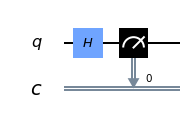

In [0]:
qubit_size = 1
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

[ Quantum Simulator ]
{'0': (0.7071067811865475+0j), '1': (-0.7071067811865475+0j)}
{'0': 0.4999999999999999, '1': 0.4999999999999999}

[ Qiskit ]
{'0': (0.7071067811865475-8.659560562354932e-17j), '1': (-0.7071067811865476+8.659560562354934e-17j)}
{'0': 505, '1': 519}



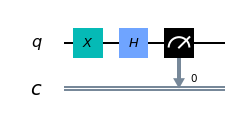

In [0]:
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

# Add special input
circuit.x(0)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

#### **2 qubit**

[ Quantum Simulator ]
{'00': (0.4999999999999999+0j), '01': (0.4999999999999999+0j), '10': (0.4999999999999999+0j), '11': (0.4999999999999999+0j)}
{'00': 0.2499999999999999, '01': 0.2499999999999999, '10': 0.2499999999999999, '11': 0.2499999999999999}

[ Qiskit ]
{'00': (0.5000000000000001+0j), '01': (0.5+0j), '10': (0.5+0j), '11': (0.4999999999999999+0j)}
{'00': 278, '11': 253, '10': 254, '01': 239}



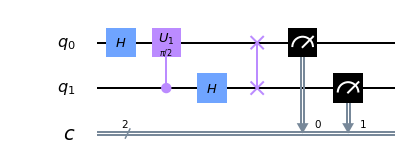

In [0]:
qubit_size = 2
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

[ Quantum Simulator ]
{'00': (0.4999999999999999+0j), '01': (-0.4999999999999999+0j), '10': (3.0616169978683824e-17+0.4999999999999999j), '11': (-3.0616169978683824e-17-0.4999999999999999j)}
{'00': 0.2499999999999999, '01': 0.2499999999999999, '10': 0.2499999999999999, '11': 0.2499999999999999}

[ Qiskit ]
{'00': (0.5-6.123233995736766e-17j), '01': (-0.5000000000000001+6.123233995736767e-17j), '10': (9.184850993605147e-17+0.4999999999999999j), '11': (-9.184850993605148e-17-0.5j)}
{'00': 256, '11': 251, '10': 268, '01': 249}



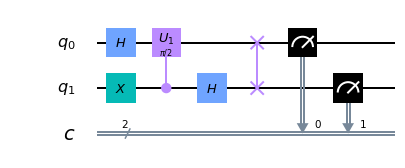

In [0]:
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

# Add special input
circuit.x(1)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

#### **3 qubit**

[ Quantum Simulator ]
{'000': (0.3535533905932737+0j), '001': (0.3535533905932737+0j), '010': (0.3535533905932737+0j), '011': (0.3535533905932737+0j), '100': (0.3535533905932737+0j), '101': (0.3535533905932737+0j), '110': (0.3535533905932737+0j), '111': (0.3535533905932737+0j)}
{'000': 0.12499999999999994, '001': 0.12499999999999994, '010': 0.12499999999999994, '011': 0.12499999999999994, '100': 0.12499999999999994, '101': 0.12499999999999994, '110': 0.12499999999999994, '111': 0.12499999999999994}

[ Qiskit ]
{'000': (0.35355339059327384+0j), '001': (0.3535533905932738+0j), '010': (0.3535533905932738+0j), '011': (0.35355339059327373+0j), '100': (0.3535533905932738+0j), '101': (0.35355339059327373+0j), '110': (0.35355339059327373+0j), '111': (0.3535533905932737+0j)}
{'001': 132, '110': 136, '100': 126, '010': 117, '111': 124, '000': 117, '101': 141, '011': 131}



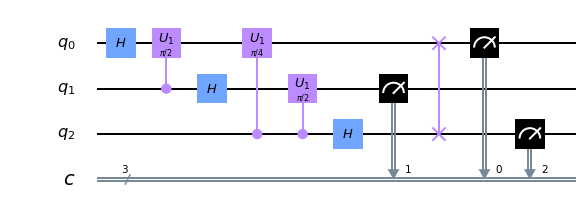

In [0]:
qubit_size = 3
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

[ Quantum Simulator ]
{'000': (-4.2549772187918565e-17-1.8059056771837343e-18j), '001': (7.480306238560716e-19-1.7624692716121393e-17j), '010': (3.136420060253988e-17-2.8810264301500075e-17j), '011': (-1.1933602209234756e-17-1.299147726256242e-17j), '100': (0.9999999999999994+6.123233995736761e-17j), '101': (-1.8488927466117464e-32+3.175897725976482e-34j), '110': (1.2447490626286985e-17-1.6027199646663898e-32j), '111': (-1.2447490626287022e-17+2.282535501389835e-32j)}
{'000': 1.8137444085586527e-33, '001': 3.11189343151929e-34, '010': 1.8137444085586527e-33, '011': 3.11189343151929e-34, '100': 0.9999999999999989, '101': 3.419413021110114e-64, '110': 1.5494002289150234e-34, '111': 1.5494002289150326e-34}

[ Qiskit ]
{'000': (5.551115123125784e-17-1.3401577416544657e-16j), '001': (5.551115123125783e-17+2.299347170293093e-17j), '010': (5.551115123125785e-17+1.3401577416544657e-16j), '011': (5.5511151231257815e-17-2.299347170293092e-17j), '100': (1-1.3110082140314586e-16j), '101': (4.80702

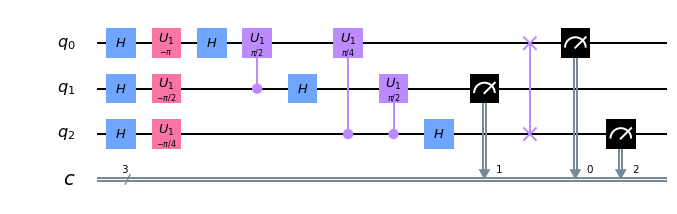

In [0]:
qubit_size = 3
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

# Add special input
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.u1(-math.pi, 0)
circuit.u1(-math.pi/2, 1)
circuit.u1(-math.pi/4, 2)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

#### **5 qubit**

[ Quantum Simulator ]
{'00000': (0.1767766952966368+0j), '00001': (0.1767766952966368+0j), '00010': (0.1767766952966368+0j), '00011': (0.1767766952966368+0j), '00100': (0.1767766952966368+0j), '00101': (0.1767766952966368+0j), '00110': (0.1767766952966368+0j), '00111': (0.1767766952966368+0j), '01000': (0.1767766952966368+0j), '01001': (0.1767766952966368+0j), '01010': (0.1767766952966368+0j), '01011': (0.1767766952966368+0j), '01100': (0.1767766952966368+0j), '01101': (0.1767766952966368+0j), '01110': (0.1767766952966368+0j), '01111': (0.1767766952966368+0j), '10000': (0.1767766952966368+0j), '10001': (0.1767766952966368+0j), '10010': (0.1767766952966368+0j), '10011': (0.1767766952966368+0j), '10100': (0.1767766952966368+0j), '10101': (0.1767766952966368+0j), '10110': (0.1767766952966368+0j), '10111': (0.1767766952966368+0j), '11000': (0.1767766952966368+0j), '11001': (0.1767766952966368+0j), '11010': (0.1767766952966368+0j), '11011': (0.1767766952966368+0j), '11100': (0.1767766952966

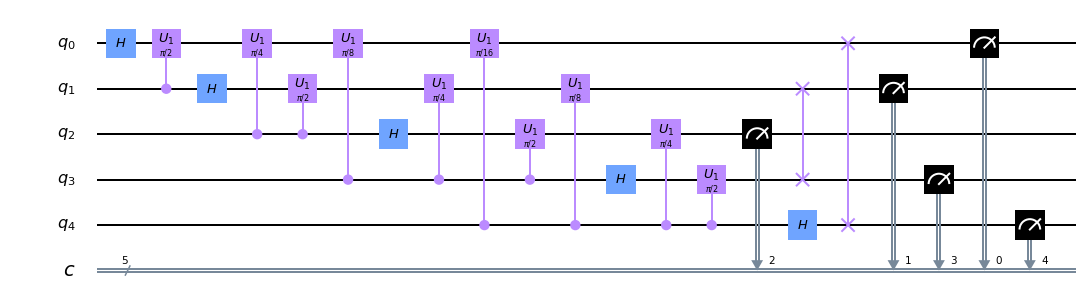

In [0]:
qubit_size = 5
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

[ Quantum Simulator ]
{'00000': (-4.0254595249368805e-17+1.0369105526307768e-17j), '00001': (-1.02126775484458e-18-3.964731577684971e-18j), '00010': (3.2650424342060346e-18-5.530728548898052e-18j), '00011': (-4.538951617911205e-18-2.6795510769084744e-18j), '00100': (1.1217801860512795e-17-8.43625722626639e-18j), '00101': (-2.5591106516463872e-18-3.4028829917508315e-18j), '00110': (6.473890260487642e-19-4.5743728191304325e-18j), '00111': (-8.558049611059101e-18-1.2111796789737303e-18j), '01000': (3.745820235302413e-17-1.8023148020978722e-17j), '01001': (-1.775125141500095e-18-3.689310916985981e-18j), '01010': (1.7425587215665348e-18-4.974491417762473e-18j), '01011': (-6.0614353305507034e-18-2.123313945772899e-18j), '01100': (5.761656714714431e-18-6.442862815697219e-18j), '01101': (-3.443781922393437e-18-3.0796696755405154e-18j), '01110': (-2.3728224469828395e-19-4.2511595029201195e-18j), '01111': (-1.4014194756857466e-17+7.822147315954393e-19j), '10000': (0.9999999999999992+6.1232339957

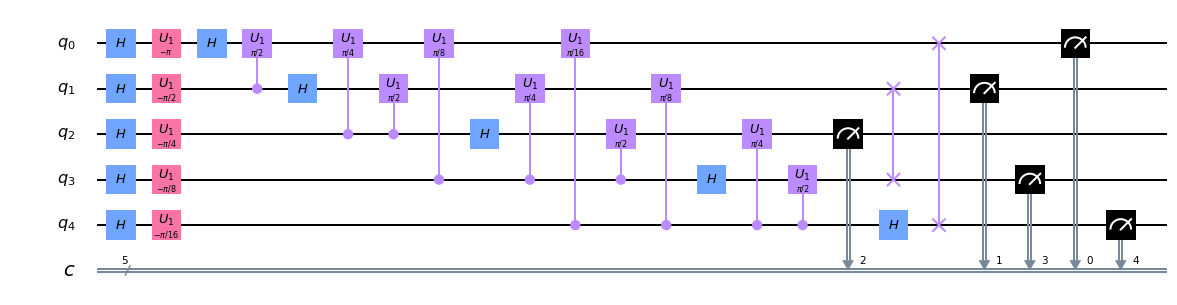

In [0]:
qubit_size = 5
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

# Add special input
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.h(4)
circuit.u1(-math.pi, 0)
circuit.u1(-math.pi/2, 1)
circuit.u1(-math.pi/4, 2)
circuit.u1(-math.pi/8, 3)
circuit.u1(-math.pi/16, 4)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')

#### **n qubit**

[ Quantum Simulator ]
{'0000000000': (0.031249999999999976+0j), '0000000001': (0.031249999999999976+0j), '0000000010': (0.031249999999999976+0j), '0000000011': (0.031249999999999976+0j), '0000000100': (0.031249999999999976+0j), '0000000101': (0.031249999999999976+0j), '0000000110': (0.031249999999999976+0j), '0000000111': (0.031249999999999976+0j), '0000001000': (0.031249999999999976+0j), '0000001001': (0.031249999999999976+0j), '0000001010': (0.031249999999999976+0j), '0000001011': (0.031249999999999976+0j), '0000001100': (0.031249999999999976+0j), '0000001101': (0.031249999999999976+0j), '0000001110': (0.031249999999999976+0j), '0000001111': (0.031249999999999976+0j), '0000010000': (0.031249999999999976+0j), '0000010001': (0.031249999999999976+0j), '0000010010': (0.031249999999999976+0j), '0000010011': (0.031249999999999976+0j), '0000010100': (0.031249999999999976+0j), '0000010101': (0.031249999999999976+0j), '0000010110': (0.031249999999999976+0j), '0000010111': (0.03124999999999997

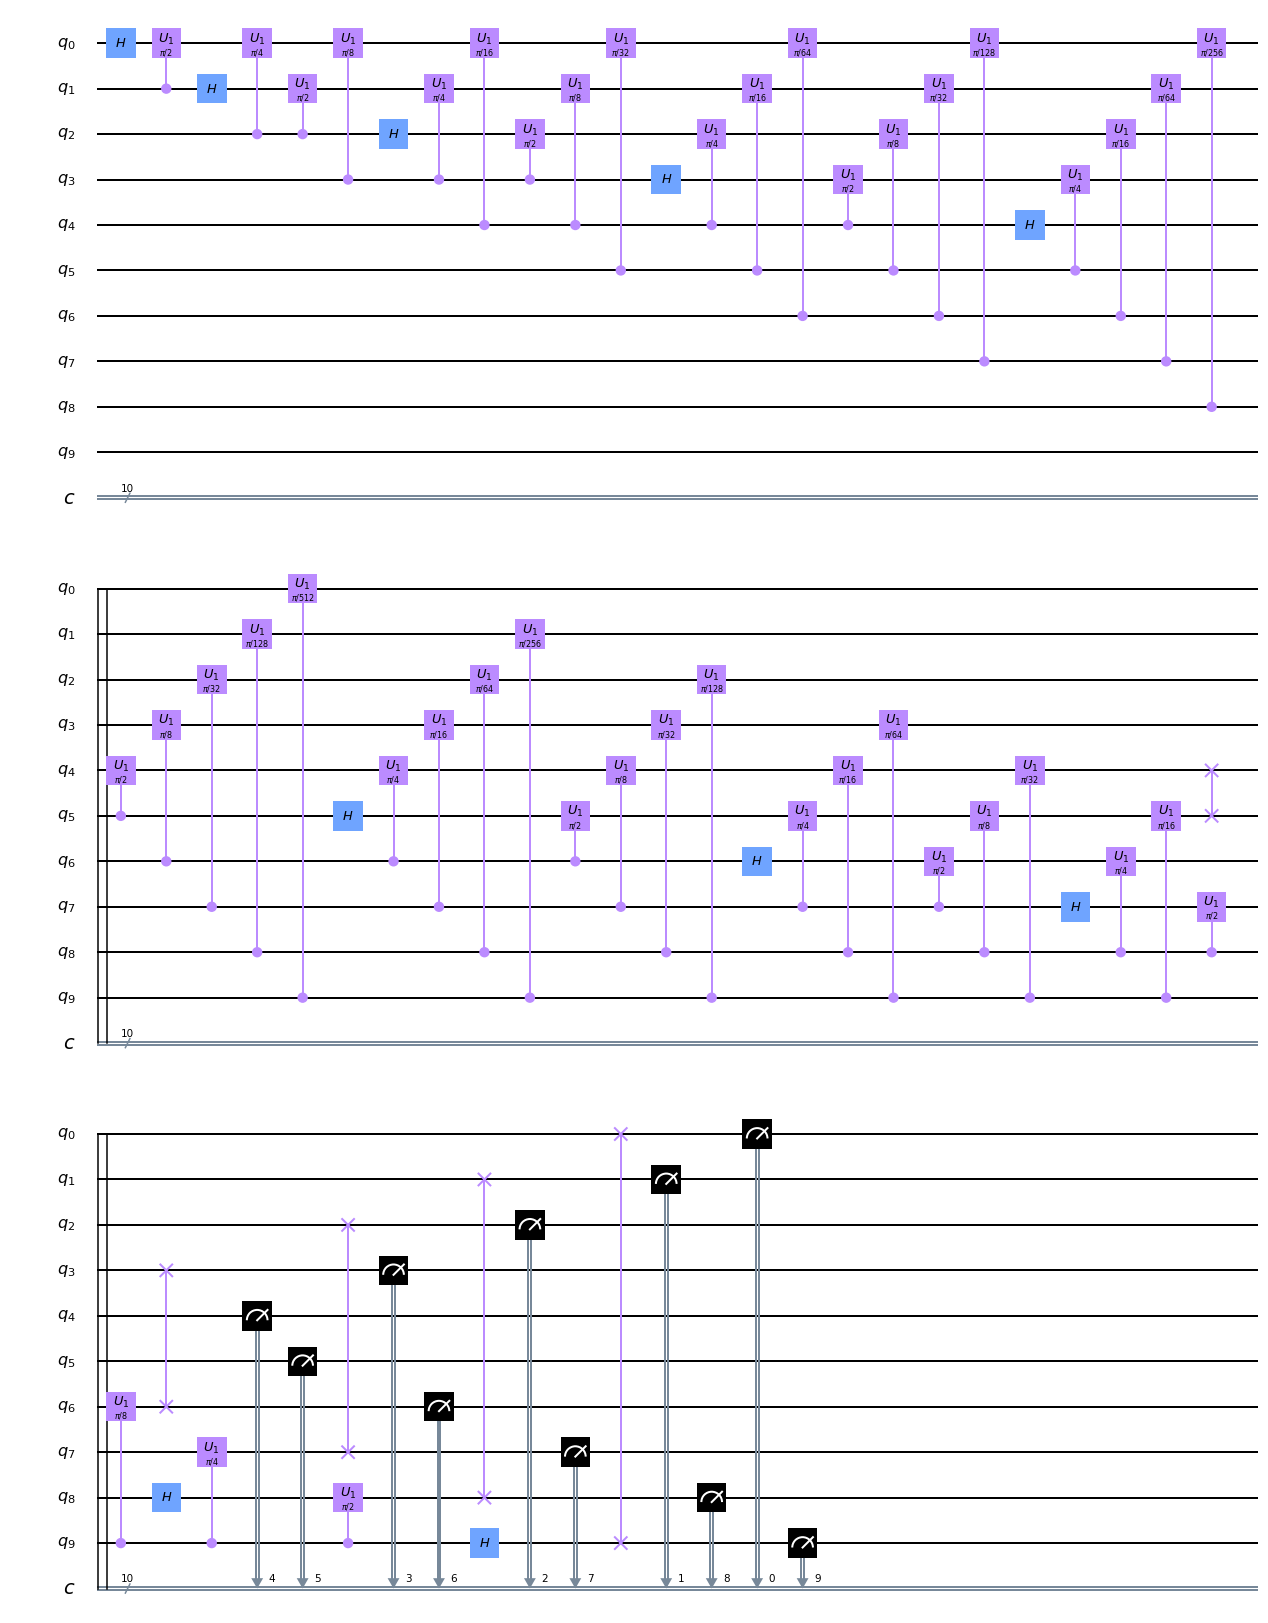

In [0]:
qubit_size = 10
# Quantum Simulator
circuit = QuantumSimulator(qubit_size)

circuit = quantum_fourier_transform(circuit, qubit_size)
print(color.BOLD + "[ Quantum Simulator ]" + color.ENDC)
print(circuit.result)
print(circuit.result_prob)
print('')

# IBMQ
ibmq_circuit_qasm, ibmq_circuit_statevector = circuit.generate_qiskit_circuit()
print(color.BOLD + "[ Qiskit ]" + color.ENDC)
print(ibmq_result(execute(ibmq_circuit_statevector, statevector_simulator).result(), qubit_size))
print(execute(ibmq_circuit_qasm, qasm_simulator).result().get_counts())
print('')
ibmq_circuit_qasm.draw(output='mpl')